# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from collections import Counter
from imblearn.under_sampling import OneSidedSelection, RandomUnderSampler

## Part 2: Porto Seguro’s Safe Driver Prediction

In [3]:
# Code for calculating Normalized gini coefficient
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert(len(actual) == len(pred))  
    epsilon = 1e-7
    values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)  
    values = values[np.lexsort((values[:, 2], -1 * values[:, 1]))]  
    total = values[:, 0].sum() 
    gini_sum = (values[:, 0].cumsum().sum() + epsilon) / (total + epsilon)  
  
    gini_sum -= (len(actual) + 1) / 2  
    return gini_sum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a)

Accuracy is not informative here and the Normalized Gini Coefficient will be used instead: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview/evaluation.

**(1.5 points)** Prove that the **Normalized Gini Coefficient** is equivalent to **2 x AUC - 1** :

According to found source  https://stats.stackexchange.com/questions/342329/gini-and-auc-relationship

Gini (mostly equal to the accuracy ratio "AR") is the ratio of the area between your curve and the diagonal and the area between the perfect model and the diagonal. This definition on the CAP curve gives the usual Gini. If you use it on the ROC curve then you see the relation to the AUC. The perfect model in the ROC is just a straight line (0% FPR and 100% TPR).

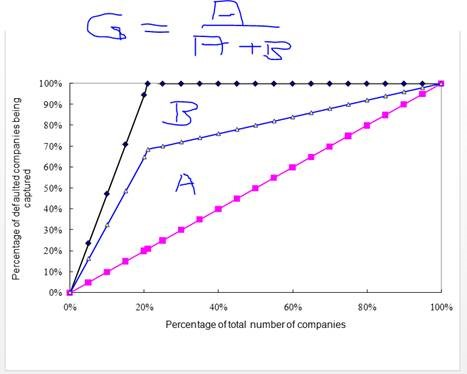

First on the CAP you get Gini by the usual formula:

Then on the ROC you see the perfect model and apply the same formual. We use that the area between the perfect model and the diagonal is 1/2 in this case:

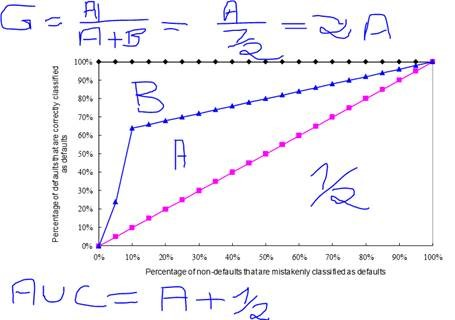

Finally, using that
A
=
G
/
2
 we get the relationship: 𝐺=2⋅𝐴𝑈𝐶−1

**(0.5 points)** By the way, what other metrics could you suggest for this problem?

##### Confusion matrix
What makes interpreting a confusion matrix valuable is the fact that it gives you a strong understanding of what types of errors your model made. 

##### Precision and recall
Precision is a valuable metric when it is important that hits really be hits, e.g. the true positive rate is what matters most. For example, a web search engine.
Recall is a valuable metric when it is important that as many relevant entries as possible are returned, e.g. keeping the false negative rate low is what matters most. For example, cancer screenings.

##### F1 score
Sometimes having two numbers per class to look at is still too much, and you want to pick just one.
The F1 score is the harmonic mean of precision and recall, which weighs each of the two equally. Its best possible value is 1 and its worst possible value is 0. One could also define and use a wieghted F1 score, if different classes have different levels of importance to your model.

##### Matthews correlation
The Matthews correlation is considered an excellent summary of the model confusion matrix because it is much less sensitive to differences in the size of the classes than more naive metrics are, like e.g. accuracy (in which accuracy for the most common type of thing will dominate).
https://www.kaggle.com/residentmario/confusion-matrices-f1-matthews-correlation-etc

**(0.5 points + Y bonus points)** Try different approaches: oversampling / undersampling, careful feature analysis and feature engineering, etc., to get a reasonable pipeline and improve the model quality. Use cross-validation for model evaluation.

Select the best model, load the test set and make the predictions. Submit them to kaggle.
Y bonus points will be calculated as $\frac{round(200 * \max(score - 0.253, 0))}{2}$, where *score* is your kaggle leaderboard score.

Note: do not use any classification models which have not been covered in the lessons yet.

### Plan
1. Preprocessing and Column Transformation
2. Balance train dataset on target
3. Building pipeline and Check result with Kaggle
4. Add Crossvalidation and check
5. Add Feature selection and check

Let's build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.
Read the detailed description and download the dataset https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data. Put the data into *./data/porto/*.

In [4]:
insurance_data = pd.read_csv('train.csv').set_index('id')
test_data = pd.read_csv('test.csv').set_index('id')

In [5]:
from collections import Counter
print(f"The data set is imbalanced: {Counter(insurance_data['target'])}")

The data set is imbalanced: Counter({0: 573518, 1: 21694})


Let's skip EDA for now. We'll use SGDClassifier and build a simple baseline: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html.
Note that loss='log' gives logistic regression.

In [6]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])

#### 1. Preprocessing and Column Transformation

According to prise keeper of this competition (https://www.youtube.com/watch?v=mbxZ_zqHV9c). All metrics with 'calc' has normal or flat distribution and artificialy added to dataset. We could check it by ourselfes through EDA, but will not spend time for it, as there are many sorces with already built visialisations on this topic. We just droping all that columns.

In [7]:
for column in X:
    if "calc" in column:
        del X[column]

In [8]:
for column in test_data:
    if "calc" in column:
        del test_data[column]

In [9]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [10]:
# from imblearn.under_sampling import NearMiss
# sampler = NearMiss(version=3)

#### 2. Balance train dataset on target

In [11]:
# oss = OneSidedSelection(random_state=42)
rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(X, y)

As you see, there are less than 4% of positive examples, so we have to deal with a highly imbalanced dataset. We will use undersampling with RandomUnderSampler, as it it is more easy way then oversampling and resampled dataset shape is quite enough for train: 21.694 records

In [12]:
print('Original dataset shape %s' % Counter(y))
print('Resampled dataset shape %s' % Counter(y_train))

Original dataset shape Counter({0: 573518, 1: 21694})
Resampled dataset shape Counter({0: 21694, 1: 21694})


#### Solution

I have tried different approaches. All of them worked despite it commented now. Last try is actual, previous tries are commented.

In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [14]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])
clf = pipeline.fit(X_train, y_train)

In [15]:
# cv_num=10

In [16]:
# model_cv=cross_validate(pipeline,X_train,y_train ,scoring='accuracy', cv=cv_num,return_estimator=True)

In [17]:
# for i in range(0,cv_num,1):
#     model=(model_cv['estimator'])[i]
#     accuracy=accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid))
#     y_pred = model.predict_proba(X_valid)[:, 1]
#     score=gini_normalized(y_valid, y_pred)
#     print('step',i,accuracy,score)

In [18]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [19]:
# model=(model_cv['estimator'])[cv_num-1]
# y_pred = model.predict_proba(X_valid)[:, 1]

In [20]:
score=gini_normalized(y_valid, y_pred)
print(score)
#0.2708327185445652 result for 0.26187 without cv

0.2708327185445652


In [21]:
# from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
# skf = StratifiedKFold(n_splits=5)
# kfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=42)
# shufflesplit = StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=1)

# for train_idx, valid_idx in shufflesplit.split(X_train, y_train):
#     X_local_train = preprocessor.fit_transform(X_train.iloc[train_idx])
#     y_local_train = y_train.iloc[train_idx].values.ravel()
#     X_local_test = preprocessor.transform(X_train.iloc[valid_idx])
#     y_local_test = y_train.iloc[valid_idx].values.ravel()
#     rus = RandomUnderSampler(random_state=42)
#     X_train, y_train = rus.fit_resample(X_local_train, y_local_train)
#     X_valid, y_valid = rus.fit_resample(X_local_test, y_local_test)


In [22]:
y_pred_test=clf.predict_proba(test_data)[:, 1]

In [23]:
output = pd.DataFrame({'id': test_data.index, 'target': y_pred_test})
output.to_csv('data/porto/porto_8.csv', index=False)

#### Kaggle private score and task score

In [24]:
#Kaggle private score
private_score=0.26187

In [25]:
task_score=round(200*np.max((private_score-0.253),0),0)/2

In [26]:
# task score
print(task_score)

1.0
